# Dependencies

In [1]:
%%capture
!pip install altair #  Altair for visualization
!pip install annoy  # Annoy for approximate nearest neighbor search
!pip install cohere # Cohere for embeddings
!pip install datasets 
!pip install -U farm-haystack>=1.3.0 
!pip install matplotlib
!pip install numpy
!pip install pinecone-client 
!pip intsall tqdm
!pip install umap-learn # Umap to reduce embeddings to 2 dimensions

In [2]:
#@title Imports
import altair as alt
from annoy import AnnoyIndex
import cohere
import csv
from datasets import load_dataset
from haystack.document_stores import PineconeDocumentStore
from haystack import Document
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import re
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import umap
# Settings
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', None)
# def seed_everything(seed, use_cuda=True):
#   # so results are reproducible!
#   random.seed(seed)
#   torch.manual_seed(seed)
#   if use_cuda: 
#     torch.cuda.manual_seed_all(seed)
#   np.random.seed(seed)

# seed_everything(42, use_cuda = True)

ModuleNotFoundError: No module named 'altair'

sign up for an API key over at [Cohere](https://os.cohere.ai/) and [Pinecone](https://app.pinecone.io)

In [3]:
COHERE_API_KEY = 'cVl4pOTR9AzNA9DpaGCscX2M6WQEbs7AM9DhX8XO'
PINECONE_API_KEY = '063315d4-bd99-478d-bd5c-7e5a3c7a7939' # app.pinecone.io



# Create and retrieve a Cohere API key from os.cohere.ai
co = cohere.Client(COHERE_API_KEY)

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Intuition behind large language models

When you hear about large language models (LLM), probably the first thing that comes to mind is the text generation capability, such as writing an essay or creating a marketing copy.

But another thing you can get is text representation: a set of numbers that represent what the text means, and somehow capture the semantics of the text. These numbers are called text embeddings.

![Comparing text generation and text representation](https://github.com/cohere-ai/notebooks/raw/main/notebooks/images/vis-embeds/1-text-gen-rep.png)

# COMMON FUNCTIONS

In [4]:
def make_histogram(dataset, col_name, name="SQUAD"):
  """
  Histogram of length of sentences in the question field/column in the dataset
  """
  num_tokens = []  # each sentence should add an integer to this list.

  # Make a histogram of the lengths of sentences in the dataset. 
  pbar = tqdm(total=len(dataset), leave=True, position=0)
  for entry in dataset:
    tokens = entry[col_name].split()
    num_tokens.append(len(tokens))
    pbar.update()
  pbar.close()

  plt.figure()
  # create the histogram
  plt.hist(num_tokens, bins=4)
  # add labels
  plt.xlabel("Number of tokens")
  plt.xlim(0, 50)
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Token Counts in Questions in the {name} Dataset")

  plt.savefig(f"{name}-{col_name}.png", format="png")

  # display the plot
  plt.show()
  return num_tokens

# Stanford Question Answering Dataset (SQuAD)
is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

You can download the dataset from the Hugging Face Hub.
For more info, visit ->  [Squad Dataset](https://huggingface.co/datasets/squad)

In [5]:
%%capture

# Get dataset, both splits 
squad_dataset = load_dataset("squad", split="train+validation")

An example row:
<blockquote>
    
    "answers": {
    "answer_start": [1],
    "text": ["This is a test text"]
    },
    "context": "This is a test context.",
    "id": "1",
    "question": "Is this a test?",
    "title": "train test"}
</blockquote>

Data Fields

<blockquote>

- id: a string feature.
- title: a string feature.
- context: a string feature.
- question: a string feature.
- answers: a dictionary feature containing:
  - text: a string feature.
  - answer_start: a int32 feature.
  
</blockquote>

## Data Exploration and Visualization



In [6]:
print(f"Number of rows: {squad_dataset.num_rows}")

print(f"Number of columns: {squad_dataset.num_columns}")

entry = squad_dataset[0]
print(f"An example row: {entry}")  # print first entry

print(f"Column names: {squad_dataset.column_names}") # print column names

Number of rows: 98169
Number of columns: 5
An example row: {'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [51

We can see that the question text contains a string in natural language. We would like understand some properties of the data. As a start, let's analyze the lengths of different sentences. We will make a histogram of the number of words in each question over the full corpus.

100%|██████████| 98169/98169 [00:09<00:00, 10324.38it/s]


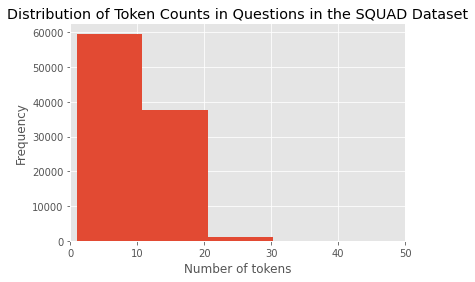

In [7]:
num_tokens = make_histogram(dataset = squad_dataset, col_name = 'question')

questions:

* How many words is the shortest question and how many sentences have that length? 
* Similarly, how many words is the longest question and how many sentences have that length?

In [8]:
from collections import Counter

token_counter = Counter(num_tokens)
shortest = min(num_tokens)
longest = max(num_tokens)
num_shortest = token_counter[shortest]
num_longest = token_counter[longest]

print(f'{num_shortest} question have {shortest} tokens.')
print(f'{num_longest} question has {longest} tokens.')

10 question have 1 tokens.
1 question has 40 tokens.


In [9]:
# print out the shortest question entries
shortest = 1
short_questions = []
for entry in squad_dataset:
  tokens = entry['question'].split()
  if len(tokens) == shortest:
    short_questions.append(entry['question'])

print(short_questions)

['k', 'j', 'n', 'b', 'v', 'dd', 'dd', 'dd', 'dd', 'd']


In [10]:
# print out the longest question entry
max_tokens = 0
longest_question = None
for entry in squad_dataset:
    tokens = entry['question'].split()
    if len(tokens) > max_tokens:
      longest_question = entry['question']
      max_tokens = len(tokens)
print(longest_question)

Which century is considered by some as a "drab" period, however saw significant advancements in the practice of medicine, mathematics, and physics, the development of biological taxonomy, a new understanding of magnetism, and the maturation of chemistry as a discipline?


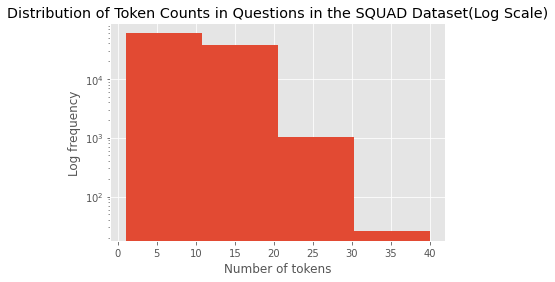

In [11]:
# Re-plot the histogram in log frequency space. 
plt.figure()
plt.hist(num_tokens, bins=4, log=True)
plt.xlabel("Number of tokens")
plt.ylabel("Log frequency")
plt.title("Distribution of Token Counts in Questions in the SQUAD Dataset(Log Scale)")
plt.savefig("SQUAD-question-log.png", format="png")
plt.show()

### Vocabulary Analysis

Next, Lets look at how the vocabulary size grows as the dataset size grows. This can help us get a gauge on when new vocabulary words (new inputs) are entering the dataset.

We will make a plot of the number of unique tokens (i.e. "vocabulary") as a function of the number of sentences in the corpus. That is, the x-axis should be a number from 0 to the length of the dataset, and the y-axis should be 
a number greater than 0 for unique count.

In [12]:
from collections import defaultdict

vocab = defaultdict(lambda: 0)
# after 0 sentences, vocab size is at 0. 
vocab_sizes = [0]

# Plot the vocabulary against the number of sentences. 
for i in tqdm(range(len(squad_dataset)), leave=True, position=0):
  entry = squad_dataset[i]
  tokens = entry['question'].split()
  for token in tokens:
    vocab[token] += 1
  vocab_sizes.append(len(vocab))

100%|██████████| 98169/98169 [00:12<00:00, 7614.57it/s]


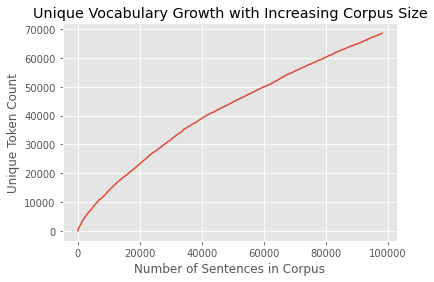

In [13]:
# PLOT
plt.figure()
plt.plot(vocab_sizes)
plt.xlabel('Number of Sentences in Corpus')
plt.ylabel('Unique Token Count')
plt.title("Unique Vocabulary Growth with Increasing Corpus Size")
plt.savefig("SQUAD-vocab-size.png", format="png")
plt.show()

* How big is the vocabulary size? 
* How big is the vocabulary for words appearing more than once? 
* How big is the vocabulary for words appearing more than three times?

In [14]:
print(f'{len(vocab)} words in vocab.')
print(f'{len([k for k in vocab if vocab[k] > 1])} words appearing > 1 times.')
print(f'{len([k for k in vocab if vocab[k] > 3])} words appearing > 3 times.')

68600 words in vocab.
32868 words appearing > 1 times.
17752 words appearing > 3 times.


Looks like vocabulary continues to grow as a function of the dataset size. There are more than 60k unique words in the vocabulary! 
One of the challenging properties is the sheer number of unique words.

Lets find the words that appear more frequently than others and also the words that appear less frequently

In [15]:
most_frequent = []
least_frequent = []

# Print the most frequent 100 words, and the least frequent 100 words. 
words = np.array(list(vocab.keys()))
counts = np.array([vocab[w] for w in words])
words_ordered = words[np.argsort(counts)[::-1]]
most_frequent = words_ordered[:111]
least_frequent = words_ordered[-100:]

print('Most frequent:')
print(most_frequent)
print()
print('Least frequent:')
print(least_frequent)

Most frequent:
['the' 'What' 'of' 'in' 'to' 'was' 'is' 'did' 'what' 'a' 'Who' 'How' 'and'
 'for' 'many' 'are' 'When' 'that' 'does' 'were' 'In' 'Which' 'on' 'with'
 'by' 'Where' 'as' 'from' 'The' 'be' 'year' 'do' 'first' 'name' 'have'
 'an' 'which' 'type' 'at' 'has' 'what?' 'used' 'can' 'most' 'their'
 'other' 'how' 'his' 'people' 'two' 'during' 'much' 'when' 'one' 'Why'
 'after' 'it' 'not' 'or' 'its' 'had' 'New' 'use' 'been' 'city' 'who'
 'about' 'between' 'known' 'part' 'would' 'to?' 'more' 'kind' 'some'
 'term' 'new' 'this' 'into' 'for?' 'group' 'than' 'country' 'made'
 'American' 'long' 'percentage' 'time' 'population' 'of?' 'called' 'take'
 'up' 'called?' 'become' 'have?' 'On' 'state' 'there' 'being' 'language'
 '?' 'system' 'considered' 'located?' 'they' 'he' 'US' 'from?' 'make'
 'British']

Least frequent:
['2039' '2037' 'imployed' '12-month' 'mid-1920s?' 'policing,' 'countires,'
 'showers?' 'dewpoint' 'DEECD?' 'XPT' 'tram-dominated' 'modernisation'
 'sprawn' 'accelerated' '1906?

After inspecting the data. Using our data analysis above, we will remove the following outliers: 

- remove the 10 questions that have 1 token.
- remove the 1 question with 40 tokens.


In [16]:
# CLEANING THE DATASET
bad_indices = []

# Type 1: too long
num_tokens = np.array(num_tokens)
sus_indices = np.arange(len(squad_dataset))[num_tokens == 40]
bad_indices.extend(sus_indices.tolist())

# Type 2: too short
sus_indices = np.arange(len(squad_dataset))[num_tokens == 1]
bad_indices.extend(sus_indices.tolist())

print(f'Number of outliers: {len(bad_indices)}.')

Number of outliers: 11.


In [17]:
print(f'Original dataset has {len(squad_dataset)} rows.')

# remove_corrupted_examples
squad_dataset = squad_dataset.filter(lambda x: len(x["question"].split()) not in (1, 40))

print(f'Cleaned dataset has {len(squad_dataset)} rows.')

Original dataset has 98169 rows.


  0%|          | 0/99 [00:00<?, ?ba/s]

Cleaned dataset has 98158 rows.


In [18]:
# convert to a pandas dataframe
squad_dataset.set_format("pandas")
df = squad_dataset[:]
print("Number of rows and columns in the cleaned dataset ->", df.shape)
# drop rows containing duplicate context passages
df = df.drop_duplicates(subset="context").reset_index(drop=True)
# select only title and context column
squad_df = df[["title", "context", "question"]]
print("Number of rows and columns in dataset after dropping duplicates and selecting relevant columns ->", squad_df.shape)

Number of rows and columns in the cleaned dataset -> (98158, 5)
Number of rows and columns in dataset after dropping duplicates and selecting relevant columns -> (20958, 3)


In [22]:
squad_df.to_csv("/content/drive/My Drive/squad_df_cleaned.csv", index=False)
squad_df.head(2)

,title,context,question
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some students believed that The Observer began to show a conservative bias, a liberal newspaper, Common Sense was published. Likewise, in 2003, when other students believed that the paper showed a liberal bias, the conservative paper Irish Rover went into production. Neither paper is published as often as The Observer; however, all three are distributed to all students. Finally, in Spring 2008 an undergraduate journal for political science research, Beyond Politics, made its debut.",When did the Scholastic Magazine of Notre dame begin publishing?


In [20]:
from datasets import Dataset

squad_dataset_cleaned = Dataset.from_pandas(squad_df)
print(squad_dataset_cleaned)

squad_dataset.reset_format()

Dataset({
    features: ['title', 'context', 'question'],
    num_rows: 20958
})


### Turn text into embeddings

In [27]:
# take only the first 1000 rows
sample_df = squad_df.sample(frac=1).reset_index(drop=True).sample(n=1000)

In [28]:
# Get text embeddings FUNCTION
def get_embeddings(texts,model='large'):
  output = co.embed(
                model=model,
                texts=texts)
  return output.embeddings

In [29]:
# Embed the dataset
sample_df['question_embeddings'] = get_embeddings(list(sample_df['question']))
sample_df.head(3)

,title,context,question,question_embeddings
9974,Israel,"In 1966, Shmuel Yosef Agnon shared the Nobel Prize in Literature with German Jewish author Nelly Sachs. Leading Israeli poets have been Yehuda Amichai, Nathan Alterman and Rachel Bluwstein. Internationally famous contemporary Israeli novelists include Amos Oz, Etgar Keret and David Grossman. The Israeli-Arab satirist Sayed Kashua (who writes in Hebrew) is also internationally known.[citation needed] Israel has also been the home of two leading Palestinian poets and writers: Emile Habibi, whose novel The Secret Life of Saeed the Pessoptimist, and other writings, won him the Israel prize for Arabic literature; and Mahmoud Darwish, considered by many to be ""the Palestinian national poet."" Darwish was born and raised in northern Israel, but lived his adult life abroad after joining the Palestine Liberation Organization.[citation needed]",Shmuel Yosef Agnon shared the Nobel Prize with who in 1966?,"[0.6538086, -1.0996094, 1.1191406, -1.1650391, -1.0361328, 0.37329102, -1.0126953, 0.08380127, 0.12133789, -0.9741211, -0.6723633, -0.61083984, -0.17590332, -1.6015625, -0.5463867, -1.6533203, -0.092285156, 1.7460938, 1.2832031, -1.1220703, -1.5742188, -0.39160156, -1.5546875, -0.26049805, 0.6791992, 2.6445312, 0.56640625, 2.2363281, -2.015625, -0.7885742, -2.40625, 1.2871094, -0.15600586, -0.8046875, 1.6630859, -0.53466797, -1.3945312, -1.9941406, 0.44311523, 0.6484375, -1.046875, -0.47973633, 0.3671875, 0.98828125, -0.4621582, 0.8901367, -1.0673828, 0.55566406, 4.1835938, 1.5048828, -0.09893799, 0.2142334, 1.5693359, -0.49169922, -0.11743164, 0.14892578, -0.52978516, -2.15625, -1.2744141, 0.82910156, -0.17456055, 1.0429688, 0.90283203, -1.1699219, 1.3681641, -1.3496094, -1.7089844, 0.35107422, -0.30371094, 0.18774414, 1.4267578, 1.4541016, -1.2568359, 0.7651367, -1.6640625, -0.47387695, 1.4755859, -0.75146484, -2.7207031, -0.09686279, 2.4082031, -0.03668213, 0.8647461, -1.3779297, -1.2363281, -0.028945923, 0.34960938, -0.72021484, -1.5205078, -1.171875, -0.09674072, -0.2298584, -2.203125, 0.0143585205, -1.3261719, -0.89453125, -0.6386719, -1.0546875, 1.7851562, -0.96972656, ...]"
4126,Newcastle_upon_Tyne,"There are several museums and galleries in Newcastle, including the Centre for Life with its Science Village; the Discovery Museum a museum highlighting life on Tyneside, including Tyneside's shipbuilding heritage, and inventions which changed the world; the Great North Museum; in 2009 the Newcastle on Tyne Museum of Antiquities merged with the Great North Museum (Hancock Museum); Seven Stories a museum dedicated to children's books, the Side Gallery historical and contemporary photography from around the world and Northern England and the Newburn Hall Motor Museum.",Where is the Science Village located?,"[-0.021072388, -0.3010254, 0.20800781, 0.34887695, -2.21875, -1.7001953, 0.33618164, 1.7558594, -0.2109375, 1.1845703, -0.43725586, 0.30688477, -2.8300781, 1.0126953, 0.10345459, -0.36450195, -0.95654297, 1.3095703, 2.1582031, -1.0800781, -0.62109375, -0.6225586, 0.65478516, -0.117614746, 1.625, -0.71435547, 2.3691406, 1.703125, 0.9189453, -0.8129883, -1.0869141, 0.9111328, -0.7939453, 1.7509766, 0.9272461, -0.37109375, -1.6699219, -1.3310547, 1.7451172, -0.5288086, 1.21875, -0.2956543, 1.4082031, -0.375, 0.6245117, 0.28466797, 0.10882568, -0.53125, -0.14172363, -0.56347656, 0.40014648, 1.5732422, -1.21875, 0.77441406, 2.046875, -0.047546387, -1.7236328, -1.2744141, -0.56152344, -1.2099609, -0.71191406, -0.2626953, 2.1210938, -0.82666016, 0.84521484, 0.13134766, -0.54589844, 0.41259766, -0.67041016, -1.7255859, 1.1806641, 1.0859375, 0.3347168, -1.4082031, -0.56103516, -0.0012731552, -0.1385498, -0.054626465, -2.0800781, 0.30078125, 0.093566895, -0.23632812, 0.71875, 1.8525391, -0.8305664, 0.24475098, 0.36791992, -0.3347168, 1.359375, 1.6953125, 0.31689453, -0.98583984, -0.6538086, -0.5083008, 0.71484375, 1.0146484, -0.5307617, -1.0830078, -1.625, 0.55126953, ...]"
16045,Intel

In [30]:
embeds = np.array(sample_df['question_embeddings'].tolist())
print(f"Total rows and Shape of embeddings -> {embeds.shape}")

Total rows and Shape of embeddings -> (1000, 4096)


### Visualize the questions

In [44]:
#@title Plot the archive {display-mode: "form"}
import umap
# UMAP reduces the dimensions from 4096 to 2 dimensions that we can plot
reducer = umap.UMAP(n_neighbors=20) 
umap_embeds = reducer.fit_transform(embeds)
# Prepare the data to plot and interactive visualization
# using Altair
df_explore = pd.DataFrame(data={'question': sample_df['question']})
df_explore['x'] = umap_embeds[:,0]
df_explore['y'] = umap_embeds[:,1]

In [50]:
# # Set sample size to visualize
# sample = 9

# # Reshape the data for visualization purposes
# source = pd.DataFrame(umap_embeds)[:sample]
# source = pd.concat([source,df['question']], axis=1)
# source = source.melt(id_vars=['question'])

# # Configure the plot
# chart = alt.Chart(source).mark_rect().encode(
#     x=alt.X('variable:N', title="Embedding"),
#     y=alt.Y('query:N', title='',axis=alt.Axis(labelLimit=500)),
#     color=alt.Color('value:Q', title="Value", scale=alt.Scale(
#                 range=["#917EF3", "#000000"]))
# )

# result = chart.configure(background='#ffffff'
#         ).properties(
#         width=700,
#         height=400,
#         title='Embeddings with 10 dimensions'
#        ).configure_axis(
#       labelFontSize=15,
#       titleFontSize=12)

# # Show the plot
# result

In [48]:
# Plot
chart = alt.Chart(df_explore).mark_circle(size=60).encode(
    x=#'x',
    alt.X('x',
        scale=alt.Scale(zero=False)
    ),
    y=
    alt.Y('y',
        scale=alt.Scale(zero=False)
    ),
    tooltip=['question']
).properties(
    width=700,
    height=400
)
chart.interactive()

alt.Chart(...)

In [ ]:
docs = []
for d in df.iterrows():
    d = d[1]
    # create haystack document object with text content and doc metadata
    doc = Document(
        content=d["question"],
        meta={
            "title": d["title"],
            'context': d['context']
        }
    )
    docs.append(doc)

In [ ]:
# Initialize the document store
document_store = PineconeDocumentStore(
    api_key=PINECONE_API_KEY,
    index='squad_qa_pinecone',
    similarity="cosine",
    embedding_dim=384
)

ForbiddenException: ignored

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data_noise_choices, data_noise_results, '-o')
plt.xlabel('Data Noise Prob', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
plt.show()

## Dataset Citation Information

<blockquote>

@article{2016arXiv160605250R,
       author = {{Rajpurkar}, Pranav and {Zhang}, Jian and {Lopyrev},
                 Konstantin and {Liang}, Percy},
        title = "{SQuAD: 100,000+ Questions for Machine Comprehension of Text}",
      journal = {arXiv e-prints},
         year = 2016,
          eid = {arXiv:1606.05250},
        pages = {arXiv:1606.05250},
archivePrefix = {arXiv},
       eprint = {1606.05250},
}

</blockquote>

# Quora Question Pairs Dataset

The Quora dataset is composed of question pairs. 

You can download the dataset from the Hugging Face Hub.
For more info, visit ->  [Quora Dataset](https://huggingface.co/datasets/quora)

An example row:
<blockquote>
    
    {
    "is_duplicate": true,
    "questions": { "id": [1, 2], "text": ["Is this a sample question?", "Is this an example question?"]}
    }

</blockquote>

Data Fields

<blockquote>

- questions: a dictionary feature containing:
  - id: a int32 feature.
  - text: a string feature.
- is_duplicate: a bool feature.
  
</blockquote>

The dataset has more than 404k questions! We are going to create a sample of 10k questions

## Data Exploration and Visualization

In [60]:
%%capture
# Quora dataset has only one split -> train
quora_dataset = load_dataset("quora", split="train")

In [70]:
size = len(quora_dataset)
print(f"Number of rows: {size}")

entry = quora_dataset[0]
print(f"An example row: {entry}")  # print first entry

print(f"Column names: {list(entry.keys())}") # print column names

Number of rows: 404290
An example row: {'questions': {'id': [1, 2], 'text': ['What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?']}, 'is_duplicate': False}
Column names: ['questions', 'is_duplicate']


In [83]:
# Keep only unique question pairs
quora_dataset = quora_dataset.filter(lambda x: x["is_duplicate"] is not True)
print("Number of rows after filtering duplicate question paris", len(quora_dataset))

# Flatten data and remove is_duplicate column
quora_dataset_flat = quora_dataset.remove_columns("is_duplicate").flatten()

  0%|          | 0/256 [00:00<?, ?ba/s]

Number of rows after filtering duplicate question paris 255027


In [87]:
def create_seperate_id_cols(example):
  return {"id1": example["questions.id"][0],
          "id2": example["questions.id"][1]}

def create_seperate_question_cols(example):
  return {"question1": example["questions.text"][0],
          "question2": example["questions.text"][1]}

In [85]:
quora_dataset_updated = quora_dataset_flat.map(create_seperate_id_cols)
quora_dataset_updated = quora_dataset_updated.map(create_seperate_question_cols)

  0%|          | 0/255027 [00:00<?, ?ex/s]

  0%|          | 0/255027 [00:00<?, ?ex/s]

In [89]:
quora_dataset_updated = quora_dataset_updated.remove_columns(["questions.id", "questions.text"])
quora_dataset_updated 

Dataset({
    features: ['id1', 'id2', 'question1', 'question2'],
    num_rows: 255027
})

In [90]:
quora_dataset_updated.set_format("pandas")

In [91]:
quora_df = quora_dataset_updated[:]

In [142]:
# Create id column
id = pd.concat([quora_df['id1'], quora_df['id2']], ignore_index=True)
# Create question column
question = pd.concat([quora_df['question1'], quora_df['question2']], ignore_index=True)

In [153]:
# create dataframe
quora_df_updated = pd.concat([id, question], ignore_index=True, axis=1)
quora_df_updated = quora_df_updated.rename(columns={0: 'id', 1: 'question'})
quora_df_updated = quora_df_updated.sort_values(by='id', ignore_index=True)
quora_df_updated = quora_df_updated.drop_duplicates(subset="id").reset_index(drop=True)

In [157]:
quora_df_updated.to_csv("/content/drive/My Drive/quora_df_updated.csv", index=False)

In [158]:
quora_df_updated.head()

,id,question
0,1,What is the step by step guide to invest in share market in india?
1,2,What is the step by step guide to invest in share market?
2,3,What is the story of Kohinoor (Koh-i-Noor) Diamond?
3,4,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
4,5,How can I increase the speed of my internet connection while using a VPN?


In [162]:
quora_dataset_updated = Dataset.from_pandas(quora_df_updated)

100%|██████████| 413109/413109 [00:14<00:00, 28162.44it/s]


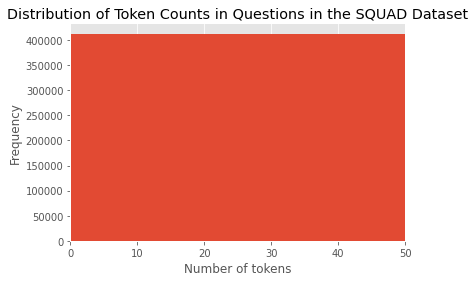

In [163]:
quora_tokens = make_histogram(dataset = quora_dataset_updated, col_name = 'question')

In [164]:
from collections import Counter

token_counter = Counter(quora_tokens)
shortest = min(quora_tokens)
longest = max(quora_tokens)
num_shortest = token_counter[shortest]
num_longest = token_counter[longest]

print(f'{num_shortest} question have {shortest} tokens.')
print(f'{num_longest} question has {longest} tokens.')

1 question have 0 tokens.
1 question has 237 tokens.


In [166]:
# print out the shortest question entries
shortest = 0
short_questions = []
for entry in quora_dataset_updated:
  tokens = entry['question'].split()
  if len(tokens) == shortest:
    short_questions.append(entry['question'])

print(short_questions)

['']


In [167]:
# print out the longest question entry
max_tokens = 0
longest_question = None
for entry in quora_dataset_updated:
    tokens = entry['question'].split()
    if len(tokens) > max_tokens:
      longest_question = entry['question']
      max_tokens = len(tokens)
print(longest_question)

Heartbreak? Heartbreak? She's my girlfriend for two months, I chose her over my girlfriend for 2 years. I like her so much to the point that I can't let her go even if she wants to end our relationship because of the other people around us most especially her family. I do the things for her that I'm not used to for a girl and I am willing to sacrifice everything just to have a little time with her. A little and limited time that I'm asking from her but she don't wanna give it to me. She's scared that someone might see us, that she's still having an affair with me. I love her and I want to be with her at least once a week even if just for a limited time. I'm not sure if I'm doing the right thing, all of my friends told me to stop it and just let it go 2 months is just 2 months not a deep relationship. But they don't feel what I feel, in this span of time I learned a lot, I learned how to love, to be loved, to sacrifice a good life, and to sacrifice a better clear future. My mind tells m

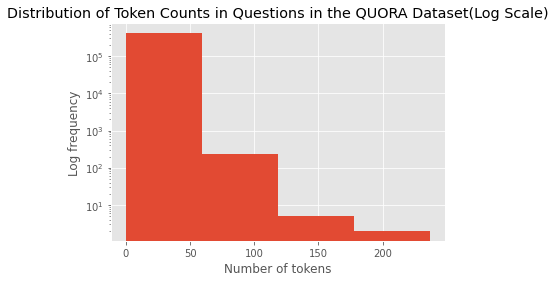

In [169]:
# Re-plot the histogram in log frequency space. 
plt.figure()
plt.hist(quora_tokens, bins=4, log=True)
plt.xlabel("Number of tokens")
plt.ylabel("Log frequency")
plt.title("Distribution of Token Counts in Questions in the QUORA Dataset(Log Scale)")
plt.savefig("QUORA-question-log.png", format="png")
plt.show()

## Vocab

In [170]:
from collections import defaultdict

vocab = defaultdict(lambda: 0)
# after 0 sentences, vocab size is at 0. 
vocab_sizes = [0]

# Plot the vocabulary against the number of sentences. 
for i in tqdm(range(len(quora_dataset_updated)), leave=True, position=0):
  entry = quora_dataset_updated[i]
  tokens = entry['question'].split()
  for token in tokens:
    vocab[token] += 1
  vocab_sizes.append(len(vocab))

100%|██████████| 413109/413109 [00:33<00:00, 12407.54it/s]


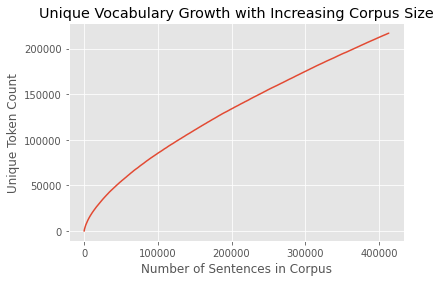

In [171]:
# PLOT
plt.figure()
plt.plot(vocab_sizes)
plt.xlabel('Number of Sentences in Corpus')
plt.ylabel('Unique Token Count')
plt.title("Unique Vocabulary Growth with Increasing Corpus Size")
plt.savefig("QUORA-vocab-size.png", format="png")
plt.show()

In [172]:
print(f'{len(vocab)} words in vocab.')
print(f'{len([k for k in vocab if vocab[k] > 1])} words appearing > 1 times.')
print(f'{len([k for k in vocab if vocab[k] > 3])} words appearing > 3 times.')

216896 words in vocab.
85814 words appearing > 1 times.
47135 words appearing > 3 times.


In [173]:
most_frequent = []
least_frequent = []

# Print the most frequent 100 words, and the least frequent 100 words. 
words = np.array(list(vocab.keys()))
counts = np.array([vocab[w] for w in words])
words_ordered = words[np.argsort(counts)[::-1]]
most_frequent = words_ordered[:111]
least_frequent = words_ordered[-100:]

print('Most frequent:')
print(most_frequent)
print()
print('Least frequent:')
print(least_frequent)

Most frequent:
['the' 'What' 'a' 'is' 'I' 'to' 'in' 'How' 'of' 'and' 'are' 'do' 'for'
 'you' 'can' 'it' 'Why' 'my' 'Is' 'on' 'best' 'or' 'does' 'with' 'an'
 'have' 'that' 'be' 'some' 'get' 'from' 'Which' 'should' 'at' 'if' 'Can'
 'your' 'like' 'good' 'there' 'as' 'when' 'people' 'would' 'not' 'between'
 'what' 'about' 'any' 'by' 'If' 'one' 'we' 'will' 'most' 'Do' 'they' 'how'
 'make' 'am' 'this' 'was' 'Who' 'Where' 'after' 'did' 'so' 'much' 'use'
 'me' 'their' 'way' 'Does' 'difference' 'India?' 'many' 'but' 'Are' 'than'
 'has' 'want' 'know' 'more' 'who' 'find' "What's" 'all' 'other' 'someone'
 'think' 'Should' 'which' 'without' 'into' 'take' 'Indian' 'learn' 'India'
 "don't" 'feel' 'new' 'he' 'out' 'work' 'job' 'become' 'time' 'first'
 "I'm" 'better' 'When']

Least frequent:
['Raveena' '"From' '"Hilario?"' 'alps' '"Nene"' 'Hilario' 'Nene' "game'?"
 "'passout" "Sprint's" '(UK,' '2-hydroxy-2-methylpropanoic' 'cell),'
 'Populizers"' 'CL"' 'type-a' 'type-c' 'Type-B?' 'Nye,' 'Tyson,'
 'late

In [174]:
# CLEANING THE DATASET
bad_indices = []

# Type 1: too long
num_tokens = np.array(quora_tokens)
sus_indices = np.arange(len(quora_dataset_updated))[num_tokens == 237]
bad_indices.extend(sus_indices.tolist())

# Type 2: too short
sus_indices = np.arange(len(quora_dataset_updated))[num_tokens == 0]
bad_indices.extend(sus_indices.tolist())

sus_indices = np.arange(len(quora_dataset_updated))[num_tokens == 1]
bad_indices.extend(sus_indices.tolist())

print(f'Number of outliers: {len(bad_indices)}.')

Number of outliers: 67.


In [177]:
print(f'Original dataset has {len(quora_dataset_updated)} rows.')

# remove_corrupted_examples
quora_dataset_cleaned = quora_dataset_updated.filter(lambda x: len(x["question"].split()) not in (0,1,237))

print(f'Cleaned dataset has {len(quora_dataset_cleaned)} rows.')

Original dataset has 413109 rows.


  0%|          | 0/414 [00:00<?, ?ba/s]

Cleaned dataset has 413042 rows.


In [181]:
quora_dataset_cleaned.set_format("pandas")

In [182]:
quora_df_cleaned = quora_dataset_cleaned[:]

In [184]:
quora_df_cleaned.head()

,id,question
0,1,What is the step by step guide to invest in share market in india?
1,2,What is the step by step guide to invest in share market?
2,3,What is the story of Kohinoor (Koh-i-Noor) Diamond?
3,4,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
4,5,How can I increase the speed of my internet connection while using a VPN?


In [185]:
quora_df_cleaned.to_csv("/content/drive/My Drive/quora_df_cleaned.csv", index=False)